# A Thaliana dataset: Finding the best cd-hit threshold

## Task

After the outliers were found and removed from the dataset, which improved classification performance, it is now time to find a good sequence clustering threshold for the dataset. Clustering is performed through a self-written python wrapper for cd-hit.

Sequence clustering is important for this task, because it reduces dependency between the test set and the training set, as well as reduncancy. 

The sequence identity threshold is defined by cd-hit as: "number of identical amino acids or bases in alignment divided by the full length of the shorter sequence".

The default threshold of cd-hit is 90%, some other publications have used a transporter dataset with 70% threshold. On the other hand, those other publications classified transporters independently of organism, so maybe 90% is more appropriate for looking at one organism at a time.

## Imports

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from joblib import Parallel, delayed

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone

from imblearn.under_sampling import RandomUnderSampler

sys.path.append("../src")
from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from models.eval import nested_crossval


## Creating the transporter dataset, without outliers

In [2]:
LOG_FILE = "../logs/meta_amino_sugar.log"
N_THREADS = 16
ORGANISM = "meta_nohuman_noyeast"

# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass
# e coli, a thaliana, human
create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    outliers=["P76773", "Q47706", "P64550", "P02943", "P75733", "P69856"]
    + ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
    + ["Q9HBR0", "Q07837"],
    tax_ids_filter=[3702, 83333],
    output_tsv=f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log=LOG_FILE,
)


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
P36672,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,treB b4240 JW4199,PTS system trehalose-specific EIIBC component ...,4.A.1.2.4,83333,MMSKINQTDIDRLIELVGGRGNIATVSHCITRLRFVLNQPANARPK...
...,...,...,...,...,...,...,...,...
Q9FDZ5,Sugar transport,Membrane;Transmembrane,Antiport;Transport,URGT6 At1g34020 F12G12.16 T15K4.8,UDP-rhamnose/UDP-galactose transporter 6 (UDP-...,NaN,3702,MAPVSKADKKAAVDAAAWMFNVVTSVGIIIVNKALMATYGYSFATT...
F4IHS9,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Antiport;Transport,UXT1 At2g28315 T1B3.18,UDP-xylose transporter 1,NaN,3702,MGEMKSMQMGVIGALFLSVASSVSIVICNKALMTNLGFPFATTLTS...
P33361,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,yehY b2130 JW2118,Glycine betaine uptake system permease protein...,3.A.1.12.15,83333,MTYFRINPVLALLLLLTAIAAALPFISYAPNRLVSGEGRHLWQLWP...


## Creating AAC features for all thresholds

In [3]:
for identity_threshold in range(40, 101, 10):
    cd_hit(
        executable_location="cd-hit",
        input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
        output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{identity_threshold}.fasta",
        log_file=LOG_FILE,
        identity_threshold=identity_threshold,
        n_threads=N_THREADS,
        memory=4096,
        verbose=True,
    )

for composition_type in ["aac", "paac"]:
    for identity_threshold in range(40, 101, 10):
        fasta_to_labels(
            input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{identity_threshold}.fasta",
            output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{identity_threshold}_labels.tsv",
        )
        calculate_composition_feature(
            input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{identity_threshold}.fasta",
            output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{identity_threshold}_{composition_type}.tsv",
            feature_type=composition_type,
        )


## Plots

### Substrate count

Sklearn reccomends 50 samples, my test have shown that models don't work reliably below 25 samples. 

A cluster threshold of at least 70% would be a good idea. 

A higher threshold would be better if:

- The overfitting and standard deviation is reduced
- The mean does not change too much, as that could indicate information sharing between training and test set.

keyword             Amino-acid transport  Sugar transport  Ratio
identity threshold                                              
40                                    62               78   0.79
50                                    71              100   0.71
60                                    76              121   0.63
70                                    84              131   0.64
80                                    92              142   0.65
90                                    97              158   0.61
100                                   98              166   0.59


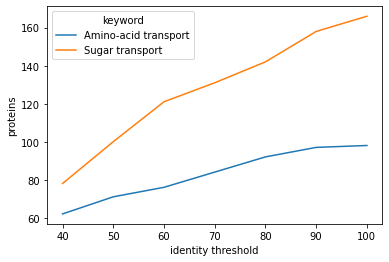

In [4]:
substrate_value_counts = []
for identity_threshold in range(40, 101, 10):
    df_vc = pd.read_table(
        f"../data/features/{ORGANISM}_amino_sugar_cluster{identity_threshold}_labels.tsv",
        index_col=0,
    ).value_counts()
    for substrate_kw in ["Sugar transport", "Amino-acid transport"]:
        substrate_value_counts.append(
            [identity_threshold, substrate_kw, df_vc[substrate_kw]]
        )
substrate_value_counts = pd.DataFrame.from_records(
    data=substrate_value_counts, columns=["identity threshold", "keyword", "proteins"]
)
sns.lineplot(
    data=substrate_value_counts.sort_values("keyword"), x="identity threshold", y="proteins", hue="keyword"
)
# plt.savefig(f"plots/{ORGANISM}_sugar_amino_clustering_samples.png", dpi=300)
results = substrate_value_counts.pivot(
    index="identity threshold", columns="keyword", values="proteins"
)
results["Ratio"] = results["Amino-acid transport"] / results["Sugar transport"]
print(results.round(2))

#### Is the 100% clustering dataset the same as the dataset without clustering?

- Happens when there are sequences that are 100% identical to each other.
- No, clustering at 100% does not change the original dataset.

In [5]:
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_labels.tsv",
)
print(
    pd.read_table(
        f"../data/features/{ORGANISM}_amino_sugar_labels.tsv",
        index_col=0,
    ).value_counts()
)
print(
    pd.read_table(
        f"../data/features/{ORGANISM}_amino_sugar_cluster100_labels.tsv",
        index_col=0,
    ).value_counts()
)


labels              
Sugar transport         166
Amino-acid transport     98
dtype: int64
labels              
Sugar transport         166
Amino-acid transport     98
dtype: int64


# Evaluation

In [6]:
def get_independent_test_set(
    df_features, df_labels_, labels=["Amino-acid transport", "Sugar transport"], test_size=0.2, random_state=42
):
    X = df_features.to_numpy()
    y = np.where(df_labels_.labels == labels[1], 1, 0)
    feature_names = df_features.columns.to_numpy()
    sample_names = df_features.index.to_numpy()
    (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
    ) = train_test_split(
        X, y, sample_names, stratify=y, random_state=random_state, shuffle=True, test_size=test_size
    )
    return (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
        feature_names,
    )


In [7]:
def print_validation_results(y_true_, y_pred_, labels = ["Amino", "Sugar"]):
    report_dict = classification_report(y_true=y_true_, y_pred=y_pred_, output_dict=True)
    report_dict = {
        labels[0]: report_dict['0'],
        labels[1]: report_dict['1'],
        "Macro": report_dict["macro avg"],
        "Weighted": report_dict["weighted avg"]
    }
    report_df = pd.DataFrame.from_dict(report_dict)
    confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true_, y_pred_),
        columns=labels,
        index=labels,
    )
    return report_df, confusion_matrix_df

In [8]:
def test_thresholds(feature_type, n_samples=20):
    records = []
    for identity_threshold in [40, 50, 60, 70, 80, 90, 100]:
        print()
        print(identity_threshold)
        for random_seed in range(n_samples):
            print(str(random_seed) + " ", end="", flush=True)
            calculate_composition_feature(
                input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{identity_threshold}.fasta",
                output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{identity_threshold}_{feature_type}.tsv",
                feature_type=feature_type,
            )
            df_features = pd.read_table(
                f"../data/features/{ORGANISM}_amino_sugar_cluster{identity_threshold}_{feature_type}.tsv",
                index_col=0,
            )
            fasta_to_labels(
                input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{identity_threshold}.fasta",
                output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{identity_threshold}_labels.tsv",
            )
            df_labels = pd.read_table(
                f"../data/features/{ORGANISM}_amino_sugar_cluster{identity_threshold}_labels.tsv",
                index_col=0,
            )
            # print(df_labels.labels.value_counts())
            (
                X_train,
                X_test,
                y_train,
                y_test,
                sample_names_train,
                sample_names_test,
                feature_names,
            ) = get_independent_test_set(
                df_features, df_labels, test_size=0.2, random_state=random_seed
            )
            params_svc = {
                "svc__class_weight": ["balanced", None],
                "svc__C": [1, 10, 100],
                "svc__gamma": [1e-1, 1e-2, 1e-3],
                "pca__n_components": np.linspace(0.8, 0.99, 20),
            }
            gsearch = GridSearchCV(
                make_pipeline(StandardScaler(), PCA(), StandardScaler(), SVC()),
                param_grid=params_svc,
                cv=5,
                scoring="f1_macro",
                n_jobs=-1,
                # return_train_score=True,
                refit=True,
            )
            gsearch.fit(X_train, y_train)
            # print(gsearch.best_params_)
            # print(gsearch.best_score_)
            best_estimator = gsearch.best_estimator_

            scores_train_sugar = cross_val_score(
                estimator=best_estimator,
                X=X_train,
                y=y_train,
                scoring=make_scorer(f1_score, pos_label=1),
            )
            scores_train_amino = cross_val_score(
                estimator=best_estimator,
                X=X_train,
                y=y_train,
                scoring=make_scorer(f1_score, pos_label=0),
            )
            records.append([identity_threshold, scores_train_sugar.mean(), "Sugar", "train"])
            records.append([identity_threshold, scores_train_amino.mean(), "Amino", "train"])
            # print(f"Train scores: {best_scores.mean().round(3)}+-{best_scores.std().round(3)}")

            y_pred = best_estimator.predict(X_test)
            y_true = y_test.copy()

            report_df, confusion_matrix_df = print_validation_results(
                y_true, y_pred, labels=["Amino", "Sugar"]
            )
            # display(report_df.round(3))
            score_amino = report_df.loc["f1-score", "Amino"]
            records.append([identity_threshold, score_amino, "Amino", "test"])
            score_sugar = report_df.loc["f1-score", "Sugar"]
            records.append([identity_threshold, score_sugar, "Sugar", "test"])
            # display(confusion_matrix_df)
    df_results = pd.DataFrame.from_records(
        records, columns=["threshold", "score", "substrate", "dataset"]
    )
    return df_results

In [9]:
df_results_aac = test_thresholds(feature_type="aac", n_samples=20)


40
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
60
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
70
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
80
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
100
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

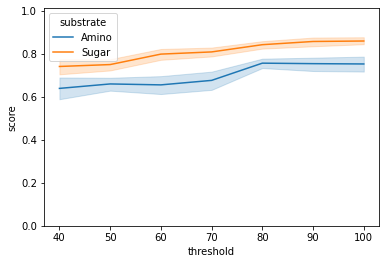

In [10]:
g = sns.lineplot(
    data=df_results_aac[df_results_aac.dataset == "test"], x="threshold", y="score", hue="substrate"
)
g.set(ylim=(0, 1.01))
plt.show()

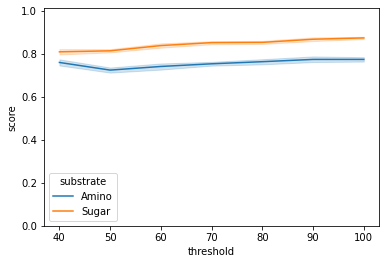

In [11]:
g = sns.lineplot(
    data=df_results_aac[df_results_aac.dataset == "train"].sort_values("substrate"),
    x="threshold",
    y="score",
    hue="substrate",
)
g.set(ylim=(0, 1.01))
plt.show()



40
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
60
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
70
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
80
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
100
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

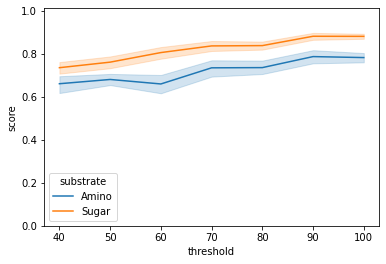

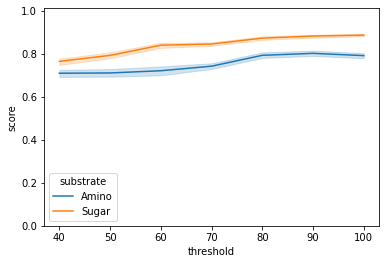

In [12]:
df_results_aac = test_thresholds(feature_type="paac", n_samples=20)
g = sns.lineplot(
    data=df_results_aac[df_results_aac.dataset == "test"].sort_values("substrate"), x="threshold", y="score", hue="substrate"
)
g.set(ylim=(0, 1.01))
plt.show()
g = sns.lineplot(
    data=df_results_aac[df_results_aac.dataset == "train"].sort_values("substrate"), x="threshold", y="score", hue="substrate"
)
g.set(ylim=(0, 1.01))
plt.show()